# Energy-Based models and structured prediction

In this assignment we're going to work with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

In [6]:
import os
os.chdir('../../../ML')

In [73]:
!ls

'Laplacian Eigenmaps'   README.md   energy_based_model.ipynb   utils
 OptimalTransport       SVD	    fonts


In [12]:
!ls fonts

font.zip


## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [1]:
! mkdir fonts


In [2]:
#! curl --output fonts/font.zip https://fonts.google.com/specimen/Anonymous+Pro
! unzip -n fonts/Anonymous_Pro.zip -d fonts
! mv fonts/AnonymousPro-Regular.ttf fonts/Anonymous.ttf


Archive:  fonts/Anonymous_Pro.zip
 extracting: fonts/OFL.txt           
 extracting: fonts/AnonymousPro-Regular.ttf  
 extracting: fonts/AnonymousPro-Bold.ttf  
 extracting: fonts/AnonymousPro-Italic.ttf  
 extracting: fonts/AnonymousPro-BoldItalic.ttf  


torch.Size([32, 18])


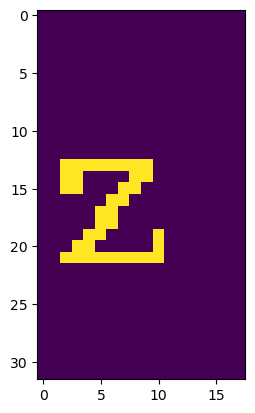

In [102]:
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt

simple_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, len=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.len = len
    self.jitter = jitter
    self.noise = noise

  def __len__(self):
    return self.len

  def __iter__(self):
    for _ in range(self.len):
        text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text

  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    pos = (0, 5)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1

    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)


    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img = next(iter(sds))[0]
print(img.shape)
plt.imshow(img)

We can look at what the entire alphabet looks like in this dataset.

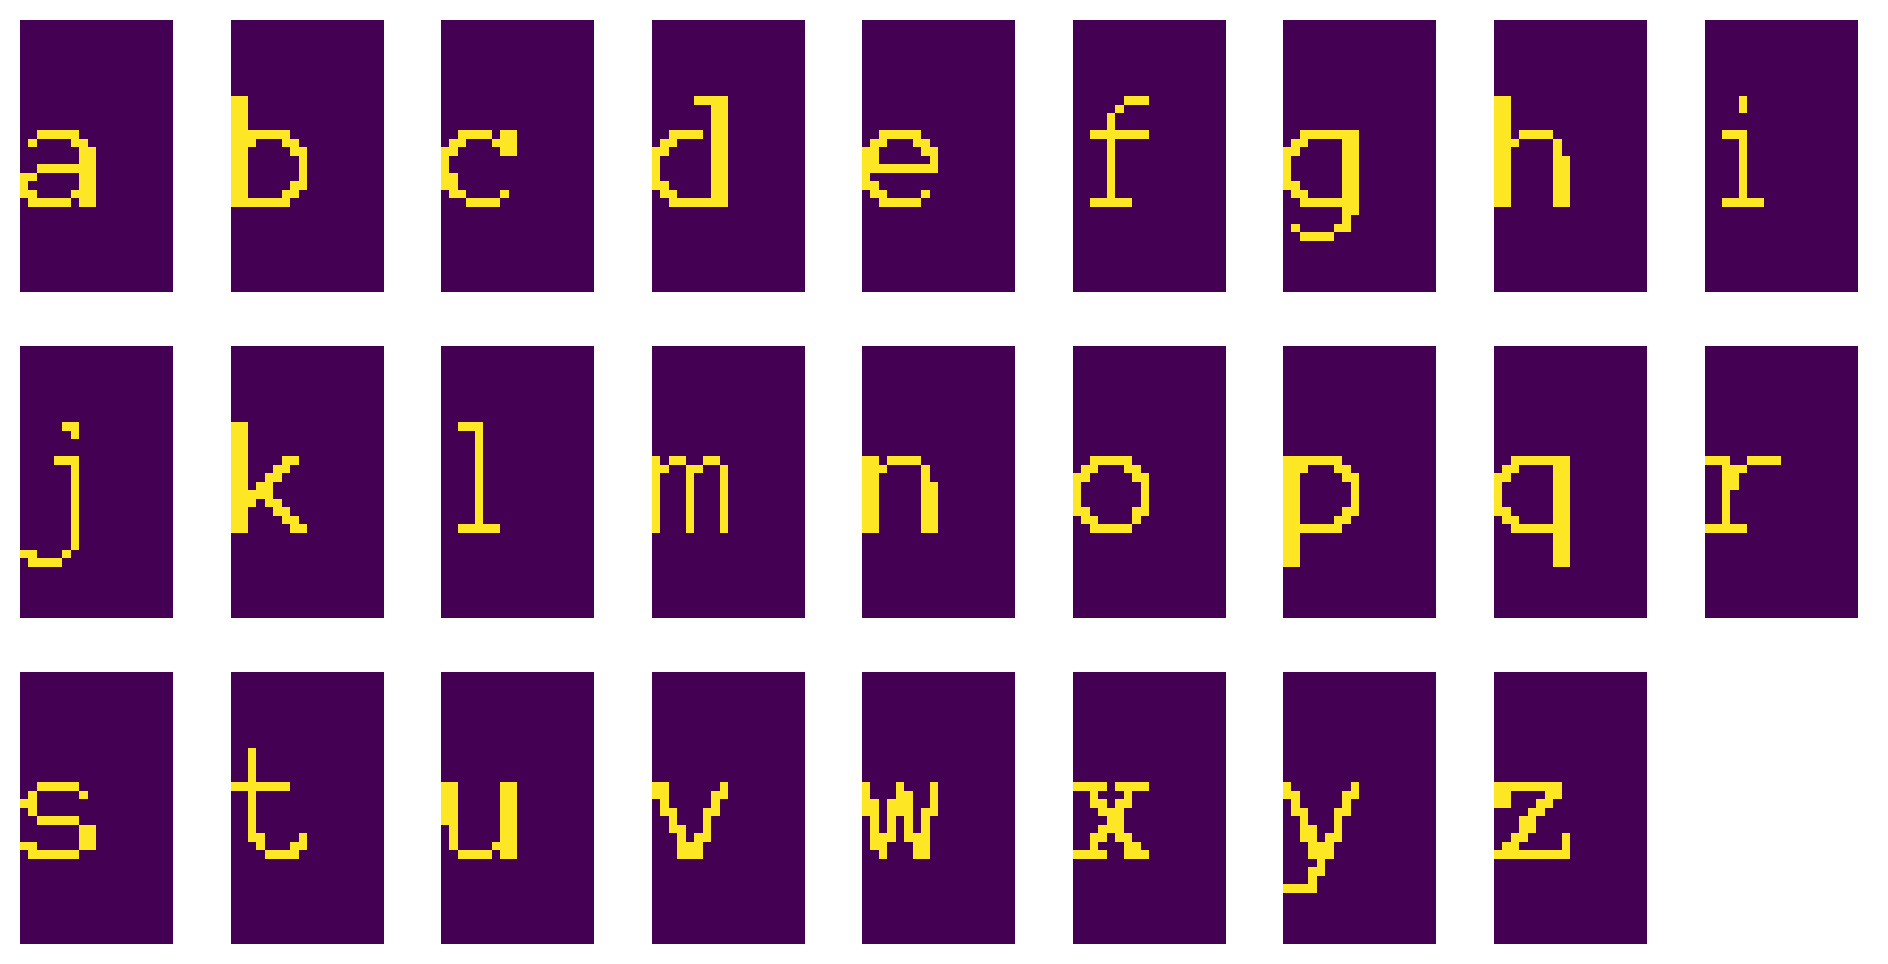

In [103]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')

plt.show()

We can also put the entire alphabet in one image.

In [147]:
alphabet[2].size()

torch.Size([340])

(np.float64(-0.5), np.float64(309.5), np.float64(31.5), np.float64(-0.5))

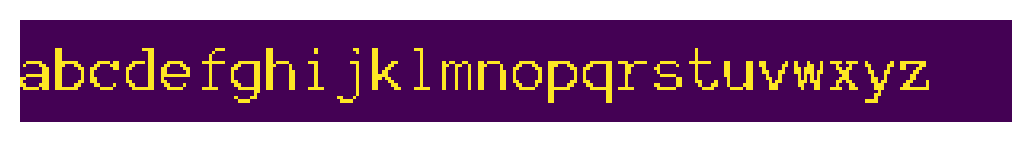

In [183]:
alphabet = sds.draw_text(string.ascii_lowercase, 310)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things.
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [105]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [106]:
from torch import nn as nn

class Block(nn.Module):
    def __init__(self, dropout=0.0, in_channels=1, out_channels=ALPHABET_SIZE, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.cnn_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x):
      return self.cnn_block(x)

class SimpleNet(nn.Module):

    def __init__(self, depth=5):
        super().__init__()

        self.cnn_proj = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4*ALPHABET_SIZE, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4*ALPHABET_SIZE),
            nn.GELU(),
            nn.Dropout2d(p=0.05)
        )

        self.cnn_blocks = nn.ModuleList([Block(dropout=0.05, in_channels=4*ALPHABET_SIZE, out_channels=4 * ALPHABET_SIZE) for _ in range(depth)])

        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels=4*ALPHABET_SIZE, out_channels=ALPHABET_SIZE, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ALPHABET_SIZE),
            nn.AdaptiveAvgPool2d((1, None))  # H -> 1, W unchanged
        )

    def forward(self, x):
        B, C, H, W = x.shape # [1, 1, 32, 18])

        x = self.cnn_proj(x)
        for blk in self.cnn_blocks:
            x = x + blk(x)        
        x = self.output_layer(x)

        # after applying cnn_block, x.shape should be:
        # batch_size, alphabet_size, 1, width
        return x[:, :, 0, :].permute(0, 2, 1)

Let's initalize the model and apply it to the alphabet image:

In [200]:
import string

def plot_energies(ce):
    fig=plt.figure(figsize=(20,6),dpi=200)
    ax = plt.axes()

    im = ax.imshow(ce.cpu().T,aspect='auto')

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticks(range(26))
    ax.set_yticklabels(list(string.ascii_lowercase))


    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()

alphabet_energies conv shape:torch.Size([1, 310, 27])


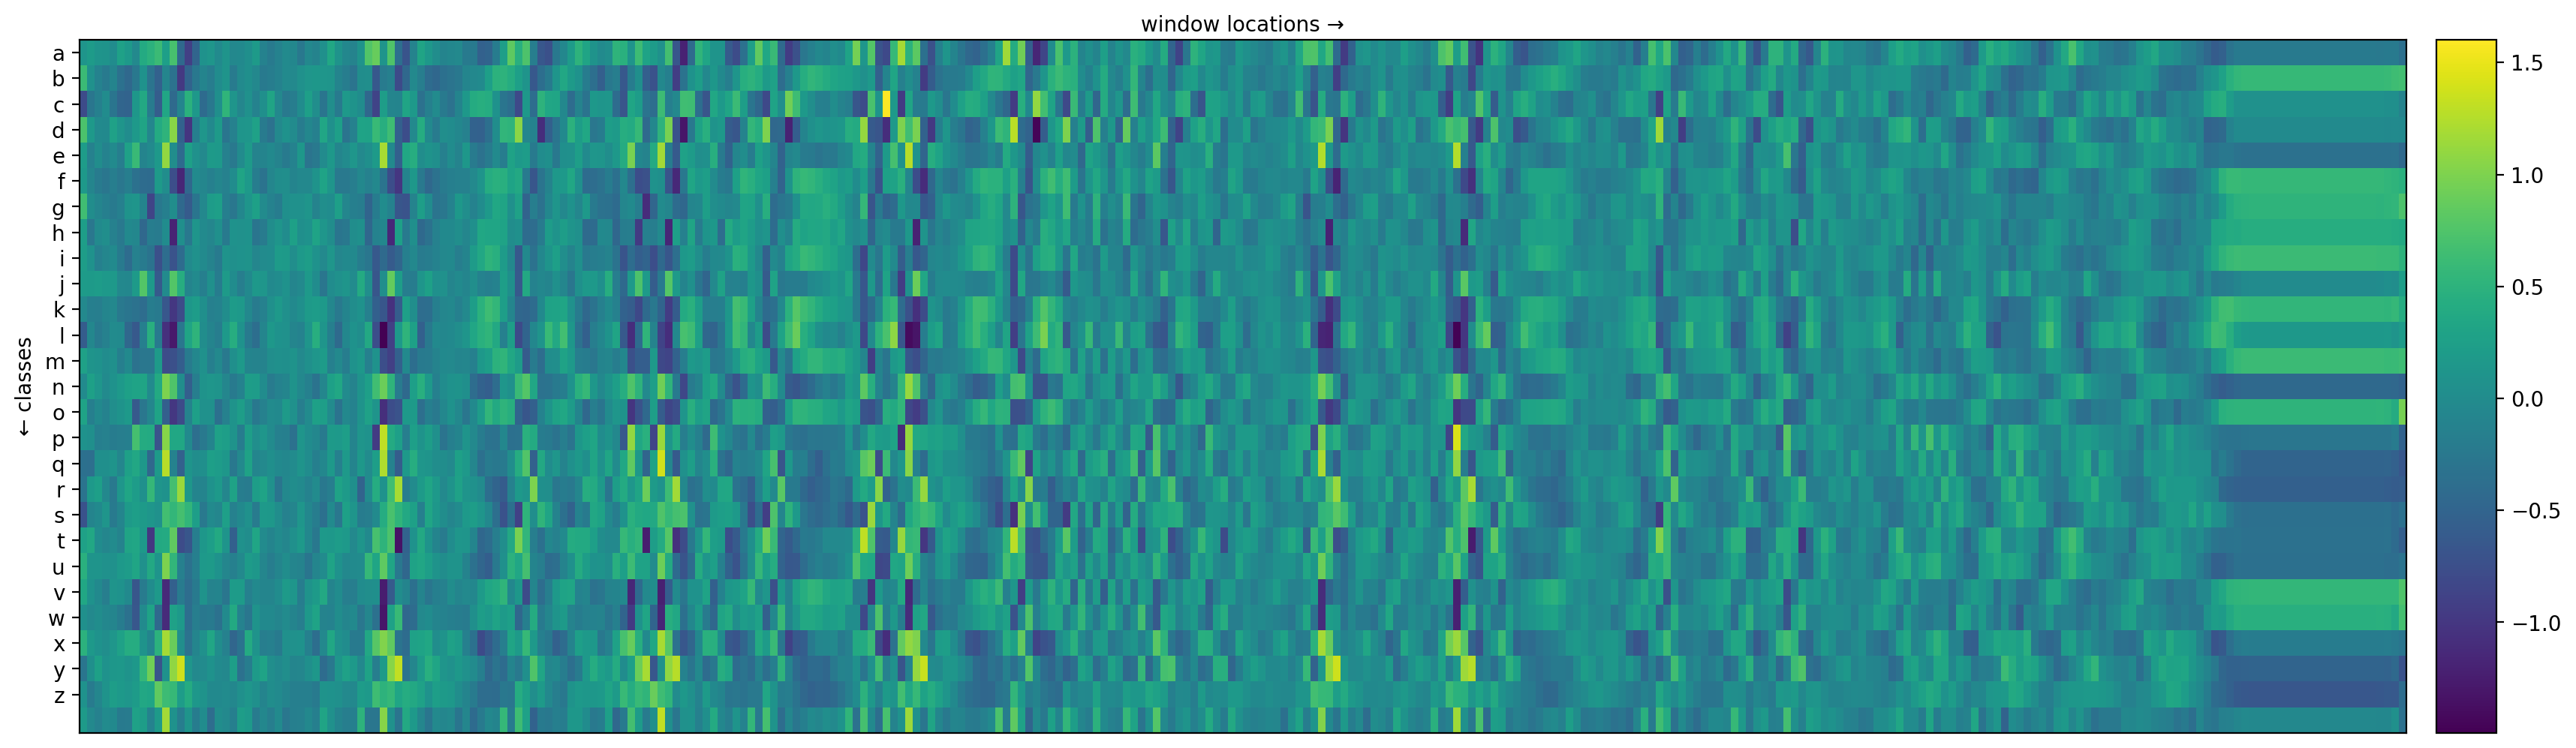

In [202]:
model = SimpleNet()
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))
print(f'alphabet_energies conv shape:{alphabet_energies.size()}')
plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [203]:
from tqdm.notebook import tqdm

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))

    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(1, len=2000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=32, num_workers=0, collate_fn=simple_collate_fn)

model.cuda()


SimpleNet(
  (cnn_proj): Sequential(
    (0): Conv2d(1, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout2d(p=0.05, inplace=False)
  )
  (cnn_blocks): ModuleList(
    (0-4): 5 x Block(
      (cnn_block): Sequential(
        (0): Conv2d(108, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Dropout2d(p=0.05, inplace=False)
      )
    )
  )
  (output_layer): Sequential(
    (0): Conv2d(108, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AdaptiveAvgPool2d(output_size=(1, None))
  )
)

In [204]:
from torch.optim.lr_scheduler import LambdaLR
import math

def cosine_scheduler_with_warmup(
    optimizer,
    warmup_steps,
    total_steps,
    initial_lr=1e-3,
    final_lr=1e-6,
):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return current_step / warmup_steps
        else:
            # Cosine decay
            progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return (final_lr / initial_lr) + (1 - (final_lr / initial_lr)) * cosine_decay

    return LambdaLR(optimizer, lr_lambda=lr_lambda)

In [205]:
initial_lr = 5e-4
final_lr = 1e-6
n_epochs = 50

steps_per_epoch = len(dataloader)
total_steps = n_epochs * steps_per_epoch

warmup_steps = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)

scheduler = cosine_scheduler_with_warmup(
    optimizer,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    initial_lr=initial_lr,
    final_lr=final_lr,
)


model.train()
for epoch in range(n_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        images, labels = batch  # images: (B, H, W), labels: (B,)
        images = images.unsqueeze(1).cuda()   # → (B, 1, H, W)
        labels = labels.cuda()

        energies = model(images) # (B, W, C) W correspond to the width of the image, if stride=1
        # We only use the energy at window position 0 (assumes 1-char word)
        #energies = torch.mean(energies, dim=1)#[:,0,:] # (B,C)
        energies = energies[:,0,:] # (B,C)

        loss = cross_entropy(energies, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update LR every step (important!)

        # Metrics
        preds = energies.argmin(dim=-1)
        total_correct += (preds == labels).sum().item()
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, accuracy={accuracy:.4f}")


Epoch 1/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1: loss=3.1832, accuracy=0.0725


Epoch 2/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2: loss=2.8006, accuracy=0.1570


Epoch 3/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3: loss=2.3399, accuracy=0.2860


Epoch 4/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4: loss=1.9614, accuracy=0.3810


Epoch 5/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5: loss=1.5905, accuracy=0.5035


Epoch 6/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6: loss=1.4072, accuracy=0.5725


Epoch 7/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7: loss=1.2418, accuracy=0.6225


Epoch 8/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8: loss=1.0798, accuracy=0.6850


Epoch 9/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9: loss=0.9662, accuracy=0.7125


Epoch 10/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: loss=0.9251, accuracy=0.7105


Epoch 11/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: loss=0.8348, accuracy=0.7545


Epoch 12/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: loss=0.7586, accuracy=0.7665


Epoch 13/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: loss=0.7494, accuracy=0.7635


Epoch 14/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: loss=0.7065, accuracy=0.7770


Epoch 15/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: loss=0.6747, accuracy=0.7760


Epoch 16/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: loss=0.6207, accuracy=0.7895


Epoch 17/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: loss=0.6177, accuracy=0.7890


Epoch 18/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: loss=0.6132, accuracy=0.7850


Epoch 19/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: loss=0.6067, accuracy=0.7840


Epoch 20/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: loss=0.5566, accuracy=0.7985


Epoch 21/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21: loss=0.5555, accuracy=0.8030


Epoch 22/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22: loss=0.4890, accuracy=0.8250


Epoch 23/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23: loss=0.5383, accuracy=0.7985


Epoch 24/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24: loss=0.4997, accuracy=0.8235


Epoch 25/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25: loss=0.4802, accuracy=0.8230


Epoch 26/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26: loss=0.4914, accuracy=0.8145


Epoch 27/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27: loss=0.4641, accuracy=0.8255


Epoch 28/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28: loss=0.4674, accuracy=0.8210


Epoch 29/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29: loss=0.4694, accuracy=0.8190


Epoch 30/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30: loss=0.4577, accuracy=0.8215


Epoch 31/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31: loss=0.4428, accuracy=0.8260


Epoch 32/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32: loss=0.4300, accuracy=0.8315


Epoch 33/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33: loss=0.4617, accuracy=0.8055


Epoch 34/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34: loss=0.4097, accuracy=0.8390


Epoch 35/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35: loss=0.4240, accuracy=0.8300


Epoch 36/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36: loss=0.4080, accuracy=0.8330


Epoch 37/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37: loss=0.4328, accuracy=0.8275


Epoch 38/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38: loss=0.3950, accuracy=0.8380


Epoch 39/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39: loss=0.4244, accuracy=0.8280


Epoch 40/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40: loss=0.4444, accuracy=0.8150


Epoch 41/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41: loss=0.4033, accuracy=0.8365


Epoch 42/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42: loss=0.4087, accuracy=0.8305


Epoch 43/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43: loss=0.4113, accuracy=0.8340


Epoch 44/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44: loss=0.4168, accuracy=0.8330


Epoch 45/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45: loss=0.3943, accuracy=0.8340


Epoch 46/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46: loss=0.4089, accuracy=0.8350


Epoch 47/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47: loss=0.4101, accuracy=0.8365


Epoch 48/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48: loss=0.3757, accuracy=0.8425


Epoch 49/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49: loss=0.3880, accuracy=0.8510


Epoch 50/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50: loss=0.3903, accuracy=0.8490


In [206]:
def get_accuracy(model, dataset):
    model.train(False)
    cnt = 0
    for i, l in dataset:
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)

tds = SimpleWordsDataset(10, len=100)
acc = get_accuracy(model, tds)
print(f'accuracy: {acc}')
assert acc == 1.0, 'Your model doesn\'t achieve 100% accuracy for 1 character'

accuracy: 1.0


Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

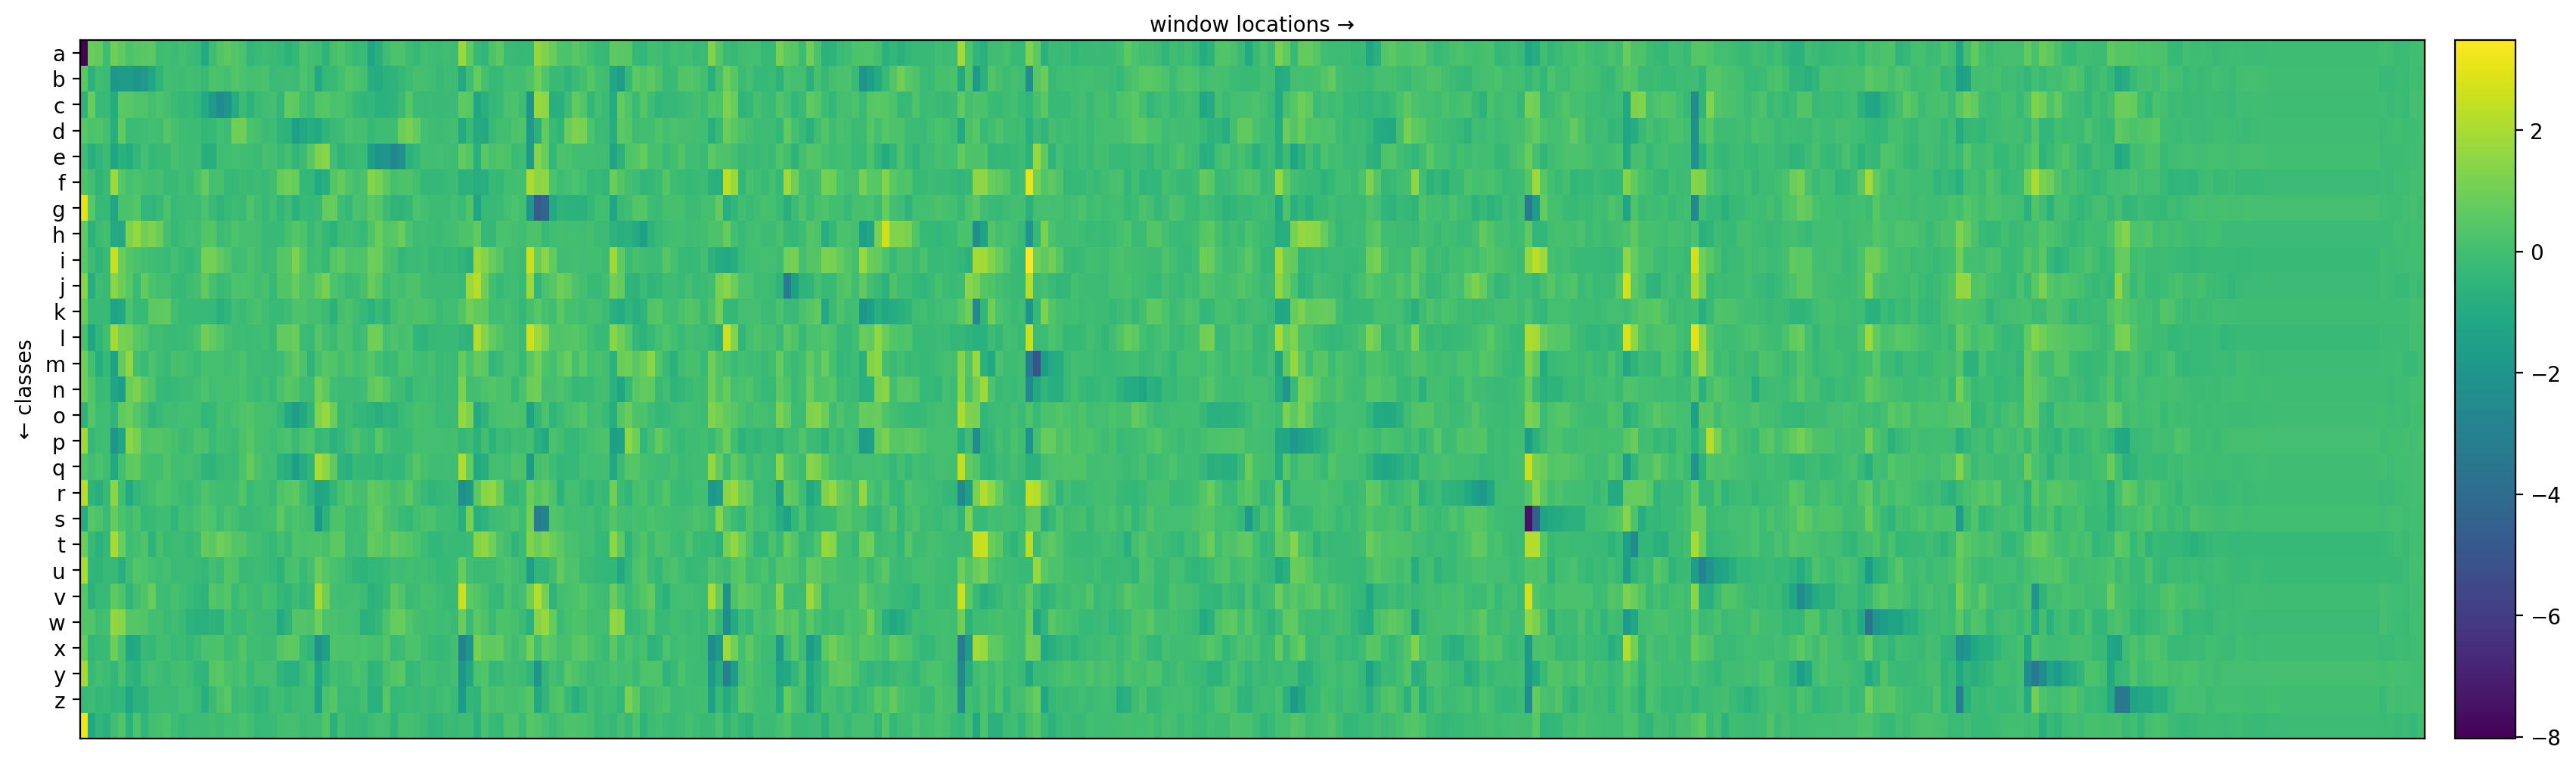

In [207]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())

Explain any classes that are lit up. What is still missing to be able to use it for transcription of words?

Answer: #TODO

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [ ]:
def build_path_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix of shape BATCH_SIZE x L x T
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO


def build_ce_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO


Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '_' models the separation between words, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc).
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [ ]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    # TODO


Now, let's plot energy table built on our model's prediction for alphabet image.

In [ ]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

energies = model(alphabet.cuda().view(1, 1, *alphabet.shape))
targets = transform_word(string.ascii_lowercase).unsqueeze(0)

pm = build_path_matrix(energies, targets)
plot_pm(energies[0].detach())

What do you see? What does the model classify correctly, and what does it have problems with?

Answer: #TODO

Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. Where does the trajectory start, and where does it end? What other properties does the trajectory have? Can you see where an optimal trajecotry would be passing through in the plot above?

Answer: #TODO

Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [ ]:
def path_energy(pm, path):
    # inputs:
    #   pm - a matrix of energies
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid



Now we can check some randomly generated paths and see the associated energies for our alphabet image:

In [ ]:
path = torch.zeros(energies.shape[1] - 1)
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path).item())

Now, generate two paths with the worst possible energy, print their energies and plot them.

In [ ]:
# TODO

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

Below, you'll need to implement this algorithm:

In [ ]:
def find_path(pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path,
    #         2. list of tuples - points of the best path in the pm matrix
    #         3. the dp array

    # TODO


Let's take a look at the best path:

In [ ]:
free_energy, path, d = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

We can also visualize the dp array. You may need to tune clamping to see what it looks like.

In [ ]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(0, 750))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [ ]:
def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# TODO: train the model
# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation.
# This is not ideal, as for loops are very slow, but for
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.

# also: remember that the loss is the sum of cross_entropies along the path, not
# energies!


Let's check what the energy matrix looks like for the alphabet image now.

In [ ]:
energies = model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase)
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

Explain how the free energy changed, and why.

Answer: #TODO

We can also look at raw energies output:

In [ ]:
alphabet_energy_post_train_viterbi = model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

How does this compare to the energies we had after training only on one-character dataset?

Answer: #TODO

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies.

In [ ]:
img = sds.draw_text('hello')
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

You should see some characters light up. Now, let's implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [ ]:
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string

    # TODO

min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

IndentationError: ignored